In [1]:
import numpy as np
from pyjet import cluster, DTYPE_PTEPM
from pyjet.testdata import get_event
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# define eta and phi ranges and number of bins along each axis
eta_min, eta_max = -4., 4.
extent = eta_min, eta_max, -np.pi, np.pi
bins = 200

In [3]:
event = get_event()

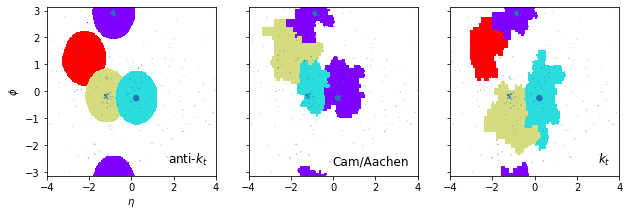

In [4]:
# create regular grid of ghosts
eta_edges = np.linspace(eta_min, eta_max, bins + 1)
phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
eta = np.linspace(eta_min, eta_max, bins + 1)[:-1] + (eta_max - eta_min) / (2 * bins)
phi = np.linspace(-np.pi, np.pi, bins + 1)[:-1] + (np.pi / bins)
X, Y = np.meshgrid(eta, phi)
ghosts = np.zeros(eta.shape[0] * phi.shape[0], dtype=DTYPE_PTEPM)
ghosts['pT'] = 1e-8
ghosts['eta'] = X.ravel()
ghosts['phi'] = Y.ravel()

# add ghosts to the event
event = np.concatenate([event, ghosts], axis=0)

fig = plt.figure(figsize=(9, 3))

ax = None
for p, label in zip((-1, 0, 1), (r'anti-$k_t$', 'Cam/Aachen', '$k_t$')):
    # cluster
    sequence = cluster(event, R=1.0, p=p)
    jets = sequence.inclusive_jets(ptmin=10)

    # pick a different color for each jet
    colors = cm.rainbow(np.linspace(0, 1, len(jets)))
    cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
    ax = fig.add_subplot(1, 3, p + 2, sharey=ax)
    area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1),
                    dtype=np.float64)
    for ijet, jet in enumerate(jets):
        constit = jet.constituents_array()
        jetarea, _, _ = np.histogram2d(constit['eta'], constit['phi'],
                                       bins=(eta_edges, phi_edges))
        area += (jetarea > 0) * (ijet + 1)

    # plot all areas
    ax.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
              extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
              interpolation='none', origin='lower')

    # overlay original event
    particles = get_event()
    ax.scatter(particles['eta'], particles['phi'],
               s=30 * particles['pT'] / particles['pT'].max())
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    if p == -1:
        ax.set_ylabel(r'$\phi$')
        ax.set_xlabel(r'$\eta$')

    ax.text(0.95, 0.05, label,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=12)

fig.subplots_adjust(hspace=0)
plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
fig.tight_layout()
#fig.savefig('jet_areas.png')